In [1]:
import sys

sys.path.insert(0, '/home/zzhuang/AdaTrans')
# !pip install dlib
from PIL import Image
from torchvision.transforms.functional import to_pil_image, to_tensor
import cv2
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
# img_path = '/home/zzhuang/DATASET/celeba-hq/celeba-256/202456.jpg'
img_path = '/home/zzhuang/DATASET/celeba/img_celeba/202456.jpg'

In [3]:
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

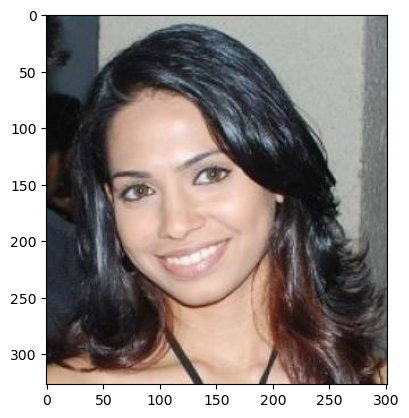

In [4]:
plt.imshow(image)

In [5]:
from models.face_align.dlib_face_align import face_alignment, face_alignment_inverse

In [6]:
aligned_image, inv_M = face_alignment(image, output_size=256)

0


In [20]:
from models.face_seg.deeplab import resnet101

deeplab_classes = ['background', 'skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear',
                   'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
deeplab_model = resnet101(
    pretrained=False,
    num_classes=len(deeplab_classes),
    num_groups=32,
    weight_std=True,
    beta=False).cuda().eval()
import torch
checkpoint = torch.load('/home/zzhuang/AdaTrans/data/deeplab_model.pth', map_location='cpu')
state_dict = {k[7:]: v for k, v in checkpoint['state_dict'].items() if 'tracked' not in k}
deeplab_model.load_state_dict(state_dict)

<All keys matched successfully>

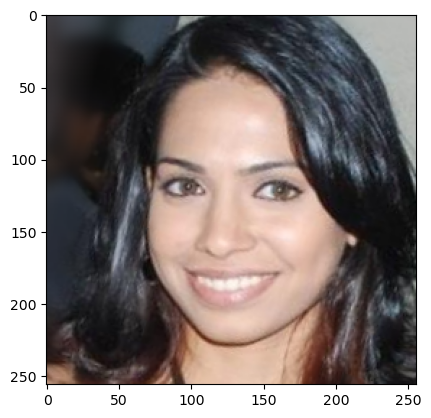

In [12]:
plt.imshow(aligned_image)

In [21]:
deeplab_input_size = 513
input = to_tensor(Image.fromarray(aligned_image).resize((deeplab_input_size, deeplab_input_size), Image.BILINEAR))
input = input.unsqueeze(0).cuda()
outputs = deeplab_model(input)

/tmp/ipykernel_12918/3396440674.py:2: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  input = to_tensor(Image.fromarray(aligned_image).resize((deeplab_input_size, deeplab_input_size), Image.BILINEAR))


In [28]:
_, pred = torch.max(outputs, 1)
seg_mask = (pred != 0).float().cpu().numpy().squeeze()

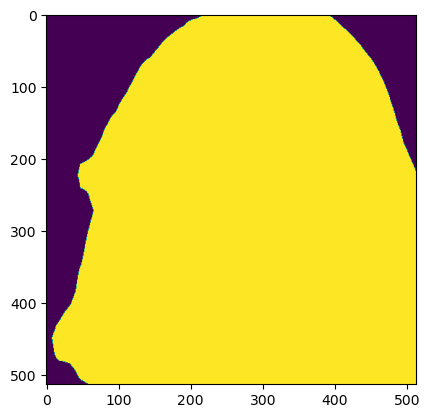

In [29]:
plt.imshow(seg_mask)

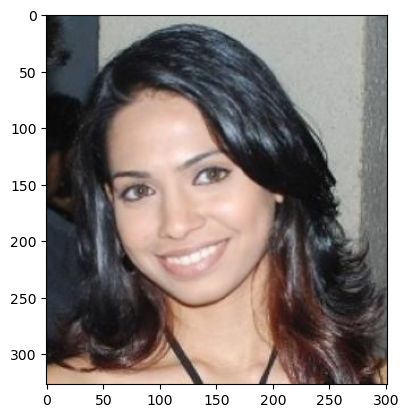

In [73]:
inversed_image = face_alignment_inverse(image, aligned_image, inv_M, 256)
plt.imshow(inversed_image)